#                                         Nurse Scheduling Algorithm (NSP)

Organizations whose employees work multiple shifts need to schedule sufficient workers for each daily shift.
Nurse scheduling is nothing but a weekly or
monthly plan for all nurses in hospital, and is
obtained by assigning shift categories to the
nurses or assigning nurses to shift. Nurse
Scheduling represents a task which consists of
creating a schedule for the nurses in a hospital.
The Nurse Scheduling Problem (NSP) is a
common problem every hospital faces every day.

#### GOAL: create a timetable that assign nurses to each shift, balancing the workload and preferences.
❖ Scheduling Period ❖ Professional Level of nurses

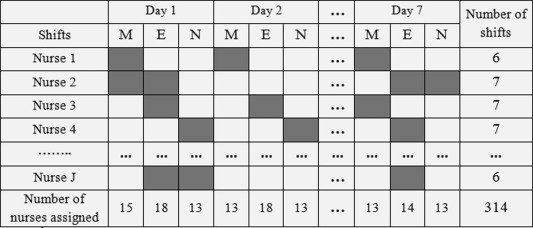

## There are two types of constraints to be taken under consideration:

### HARD CONSTRAINTS : 
If this constraint fails then the entire schedule is invalid ----> FEASIBILITY
##### Type 1 - Shift Division :  
Each day is divided into three 8-hour shifts.
##### Type 2 - Nurse Coverage: 
Every day, each shift is assigned to a single nurse, and no nurse works more than one shift.
##### Type 3 - Working Pattern: 
Each nurse is assigned to at least two shifts during the three-day period.


### SOFT CONSTRAINTS : 
It is desirable that these constraints are met but not meeting them does not make the schedule invalid. -----> OPTIMALITY 
##### Type 1 - Satisfaction/ Preferences: 
total number of Off-days = 4,
total number of night-shifts = 3, etc.


## Mathematical Representation of the Problem: 

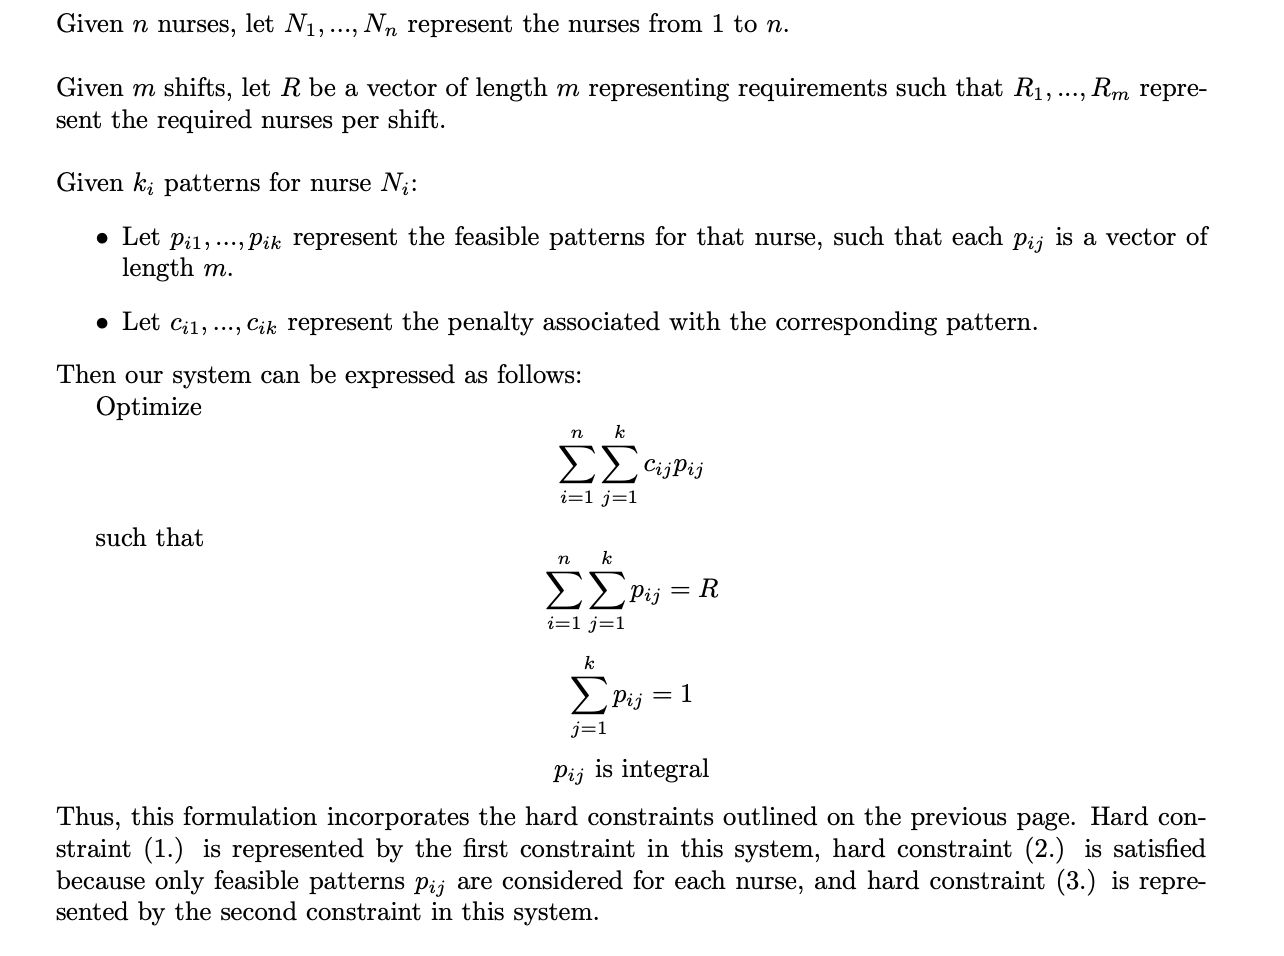

## Pyomo as optimization modeling environment: 
To solve this problem we will make use of Pyomo, in their own words a “Python-based, open-source optimization modeling language with a diverse set of optimization capabilities”. So we import its packages. 

In [ ]:
import sys
!{sys.executable} -m pip install pyomo

In [ ]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

## Define model parameters
The first step is to enter the data, this means to provide the model, in this case, the days we are considering, workers, shifts

In [ ]:
# Define days (1 week)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Enter shifts of each day
shifts = ['morning', 'evening', 'night']  # 3 shifts of 8 hours
days_shifts = {day: shifts for day in days}  # dict with day as key and list of its shifts as value

# Enter Nurse ids (name, number, ...)
nurses = ['W' + str(i) for i in range(1, 11)]  # 10 nurses available, more than needed


## Initialize model
To build the model, we need to initialize the model and create the decision variables.


In [ ]:
# Initialize model
model = ConcreteModel()

# binary variables representing if a nurse is scheduled somewhere
model.works = Var(((nurse, day, shift) for nurse in nurses for day in days for shift in days_shifts[day]),
                  within=Binary, initialize=0)

# binary variables representing if a nurse is necessary
model.needed = Var(nurses, within=Binary, initialize=0)

# binary variables representing if a nurse worked on sunday but not on saturday (avoid if possible)
model.no_pref = Var(nurses, within=Binary, initialize=0)

### We add with Var() variables to the model, indexed by lists.
#### works: 
binary variable indexed by nurses, days and shifts. 1 if the nurses has to work that day on that shift.
#### needed:
binary variable indexed by nurses. 1 if the nurse is necessary to include in the workforce.
#### no_pref: 
binary variable indexed by nurses. 1 if it does not work on Sunday but it does on Saturday.



## Define objective function.

In [ ]:
def obj_rule(m):
    c = len(nurses)
    return sum(m.no_pref[nurse] for nurse in nurses) + sum(c * m.needed[nurse] for nurse in nurses)
# we multiply the second term by a constant to make sure that it is the primary objective
# since sum(m.no_prefer) is at most len(nurses), len(nurses) + 1 is a valid constant.


# add objective function to the model. rule (pass function) or expr (pass expression directly)
model.obj = Objective(rule=obj_rule, sense=minimize)

## Add model constraints :

### We create a ConstraintList() and then add whatever constraints we want to the container with the function add.
The goal is to find a schedule that minimizes the number of workers also the number of workers that work on Sundays but not on Saturdays.

In [ ]:
model.constraints = ConstraintList()  # Create a set of constraints

# Constraint: all shifts are assigned
for day in days:
    for shift in days_shifts[day]:
        if day in days[:-1] and shift in ['morning', 'evening']:
            # weekdays' and Saturdays' day shifts have exactly two nurses
            model.constraints.add(  # to add a constraint to model.constraints set
                2 == sum(model.works[nurse, day, shift] for nurse in nurses)
            )
        else:
            # Sundays' and nights' shifts have exactly one nurse
            model.constraints.add(
                1 == sum(model.works[nurse, day, shift] for nurse in nurses)
            )

# Constraint: no more than 40 hours worked
for nurse in nurses:
    model.constraints.add(
        40 >= sum(8 * model.works[nurse, day, shift] for day in days for shift in days_shifts[day])
    )

# Constraint: rest between two shifts is of 12 hours (i.e., at least two shifts)
for nurse in nurses:
    for j in range(len(days)):
        # if working in morning, cannot work again that day
        model.constraints.add(
            1 >= sum(model.works[nurse, days[j], shift] for shift in days_shifts[days[j]])
        )
        # if working in evening, until next evening (note that after sunday comes next monday)
        model.constraints.add(
            1 >= sum(model.works[nurse, days[j], shift] for shift in ['evening', 'night']) +
            model.works[nurse, days[(j + 1) % 7], 'morning']
        )
        # if working in night, until next night
        model.constraints.add(
            1 >= model.works[nurse, days[j], 'night'] +
            sum(model.works[nurse, days[(j + 1) % 7], shift] for shift in ['morning', 'evening'])
        )

# Constraint (def of model.needed)
for nurse in nurses:
    model.constraints.add(
        10000 * model.needed[nurse] >= sum(model.works[nurse, day, shift] for day in days for shift in days_shifts[day])
    )  # if any model.works[nurses, ·, ·] non-zero, model.needed[nurse] must be one; else is zero to reduce the obj function
    # 10000 is to remark, but 5 was enough since max of 40 hours yields max of 5 shifts, the maximum possible sum

# Constraint (def of model.no_pref)
for nurse in nurses:
    model.constraints.add(
        model.no_pref[nurse] >= sum(model.works[nurse, 'Sat', shift] for shift in days_shifts['Sat'])
        - sum(model.works[nurse, 'Sun', shift] for shift in days_shifts['Sun'])
    )  # if not working on sunday but working saturday model.needed must be 1; else will be zero to reduce the obj function


## Find the solution: 
Local solver: Need to have installed glpk solver and added the executable to the path. 

In [ ]:
opt = SolverFactory('glpk')  # choose a solver
results = opt.solve(model)  # solve the model with the selected solver

## Extract the solution

In [ ]:
def get_nurses_needed(needed):
    """Extract to a list the needed nurses for the optimal solution."""
    nurses_needed = []
    for nurse in nurses:
        if needed[nurse].value == 1:
            nurses_needed.append(nurse)
    return nurses_needed


def get_work_table(works):
    """Build a timetable of the week as a dictionary from the model's optimal solution."""
    week_table = {day: {shift: [] for shift in days_shifts[day]} for day in days}
    for nurse in nurses:
        for day in days:
            for shift in days_shifts[day]:
                    if works[nurse, day, shift].value == 1:
                        week_table[day][shift].append(nurse)
    return week_table


def get_no_preference(no_pref):
    """Extract to a list the nurses not satisfied with their weekend preference."""
    return [nurse for nurse in nurses if no_pref[nurse].value == 1]


nurses_needed = get_nurses_needed(model.needed)  # dict with the optimal timetable
week_table = get_work_table(model.works)  # list with the required nurses
nurses_no_pref = get_no_preference(model.no_pref)  # list with the non-satisfied nurses (work on Sat but not on Sun)

# Types of NSP algorithms: 

#### 1. Mixed - Integer Programming:  
The model can directly represent a mixed-integer programming problem, with pij being the problem’s indicator variables. Once the model has been formulated, it can be submitted into a linear
programming solver and solved to optimality.

#### 2. Knapsack :
The model can also be formulated as a Multiple-Choice Knapsack Problem, where the knapsack
represents the requirements, and it can be “filled” by selecting one pattern from each nurse. The
model can then be solved to optimality using dynamic programming like the 0-1 Knapsack Problem.

#### 3. Tabu Search

Tabu Search is an incremental search algorithm, using the same concept as Local Neighborhood
Search to find feasible solutions. Given an initial solution, the algorithm looks for solutions that
differ only by a single value, and evaluates whether or not these solutions are an improvement upon
the original. The search then accepts the best solution out of these neighboring solutions and repeats
the process.

# Comparison of Optimality of NSP algorithms: 

Consider that we run the NSP algorithms on 4 nurses as a simple test for correctness, and 20 nurses as a standard-difficulty NSP problem. It was observed that that for the four-nurse case, both the Integer Programming and Knapsack methods generated the optimal solution in less than one second. The Tabu Search algorithm returned a suboptimal solution, although the solution was only slightly worse than the optimal one. However, in the twenty-nurse case, the Knapsack method failed to finish within an hour, while the Integer Programming method took approximately 10 minutes on average. The Tabu Search again returned a slightly suboptimal solution.

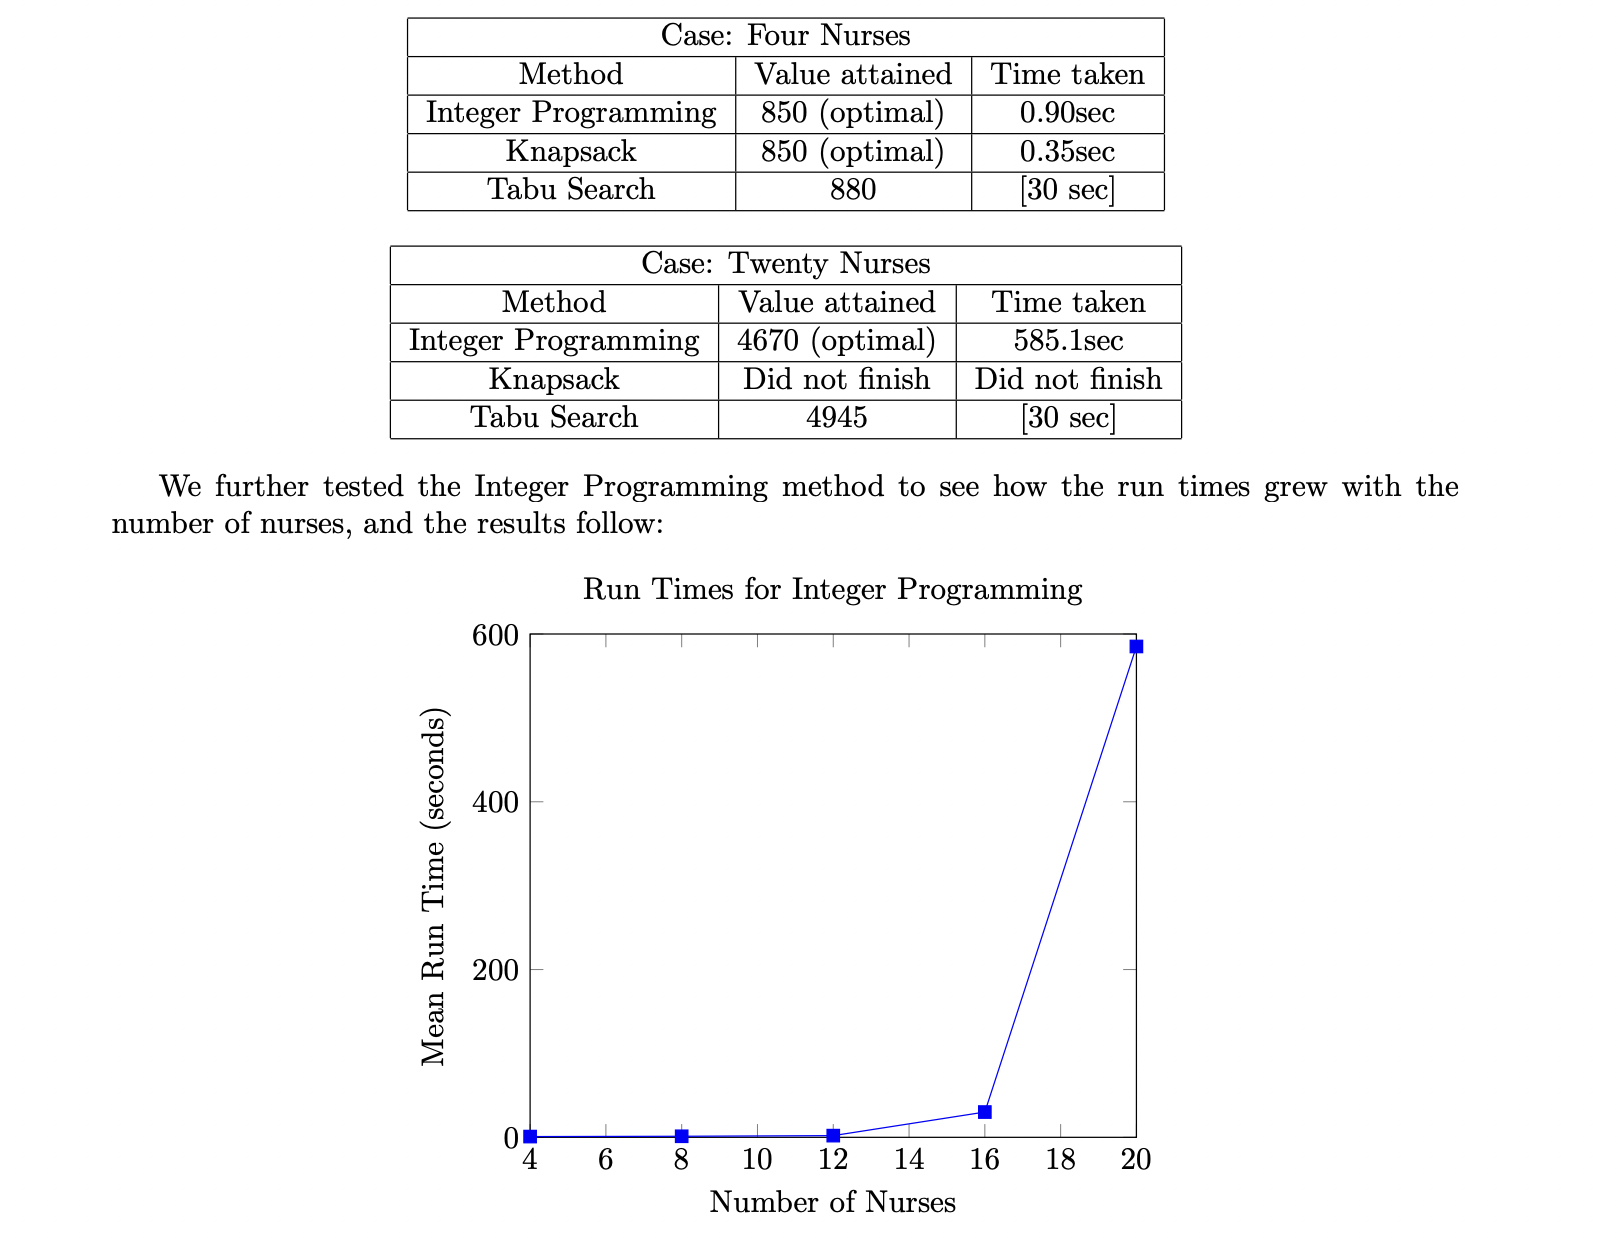


# Conclusion : 


The Nurse Scheduling Problem is an NP Hard problem and can be solved by a variety of methods and we have discussed one of the algorithms in this notebook.  The NSP algorithm to be used depends on th size of the staff that needs to be scheduled. For a small staff, using pyomo library and solving it as a mixed -integere problem would prove to be beneficial. This solution satisfies all the hard constraints assumed for our algorithm and provides an optimal solution to the problem.

# References: 

[1] Employee Scheduling Blog, Google OR-tools, Dec-2021, https://developers.google.com/optimization/scheduling/employee_scheduling#nurse_scheduling

[2] Christian Carballo Lozano, Modeling and optimization of a weekly workforce with Python and Pyomo, Nov-20, https://towardsdatascience.com/modeling-and-optimization-of-a-weekly-workforce-with-python-and-pyomo-29484ba065bb

[3] Oluwaseun M. Alade, Akeem O. Amusat, SOLVING NURSE SCHEDULING PROBLEM USING
CONSTRAINT PROGRAMMING TECHNIQUE , 2019, https://arxiv.org/pdf/1902.01193.pdf

[4] Yijing Chen, Andrew Liu, Elizabeth Sciannella, Alice Zhang, A Comparison of Approaches to the Nurse Scheduling Problem, December 2016, https://www.math.cmu.edu/~af1p/Teaching/OR2/Projects/P52/FinalPaper.pdf
